# Predicting Seasonal Flu Vaccine Status
## Lydia Cuffman and Ramses Nestor Reis

### Overview
Vaccines are a very important tool for the promotion of public health. They work best when most people get their vaccinations, leading to higher rates of group immunity and protecting those who cannot be immunized. Since vaccines are so valuable, it is useful to know whether a person is likely to pursue immunization.

### Business and Data Understanding
We have been tasked by a large healthcare organization to classify patients based on their seasonal flu shot status. In an overtaxed medical system, it is to the organization's advantage to minimize the number of flu cases. Obviously it is also to the benefit of the patients to not suffer from the flu and its possible serious consequences. By creating a model of whether a patient is likely to get their seasonal flu vaccine, we can help the organization focus efforts on reaching out to those patients who are less likely to get their shot. If the healthcare organization can vaccinate more patients, they can dedicate their finite resources to other important but perhaps less urgent needs.

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score, roc_curve, precision_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, auc


In [17]:
#Import our data and combine it into a single dataframe.
features = pd.read_csv('data/training_set_features.csv')
labels = pd.read_csv('data/training_set_labels.csv')

In [18]:
flu_df = pd.merge(features, labels, on='respondent_id', how='outer')

In [19]:
flu_df

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN,0,0
26703,26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea,0,0
26704,26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN,0,1
26705,26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,fcxhlnwr,haliazsg,0,0


In [20]:
#Check out all the features in the data, as well as how many null values we're working with.
flu_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

Most features have nulls, but not many. A few features include almost half null entries. If we remove all nulls even for just the features missing less than 10%, our whole data set would be reduced by 20%. And if we remove the columns with many nulls, we lose possibly important information about the influence of employment or health insurance status. We will need to handle nulls in another way. 

In [21]:
#Check for correlations to see if any obvious relationships leap out.
flu_df.corr()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
respondent_id,1.000000,0.017839,0.003425,-0.008475,0.009638,-0.006644,0.011105,0.004539,0.009011,0.007575,...,0.005912,0.000958,-0.002270,0.005935,-0.005291,0.009563,0.000187,-0.003726,-0.003280,-0.004652
h1n1_concern,0.017839,1.000000,0.062522,0.090301,0.233713,0.156032,0.293565,0.255031,0.246424,0.248016,...,0.239604,0.377033,0.360070,0.235136,0.333990,0.225731,-0.015658,0.050525,0.121929,0.154828
h1n1_knowledge,0.003425,0.062522,1.000000,-0.010836,0.088839,0.030050,0.089785,-0.048898,-0.068219,0.086162,...,0.121009,0.073086,-0.019501,0.086103,0.076825,-0.062483,0.024874,0.050583,0.117951,0.120152
behavioral_antiviral_meds,-0.008475,0.090301,-0.010836,1.000000,0.049247,0.146261,0.064119,0.106287,0.127679,0.070868,...,0.030211,0.105163,0.079091,0.015003,0.085315,0.084305,0.044900,0.084822,0.040608,0.006277
behavioral_avoidance,0.009638,0.233713,0.088839,0.049247,1.000000,0.064946,0.338130,0.227675,0.220348,0.335335,...,0.112300,0.117851,0.131405,0.119554,0.129504,0.082942,0.019122,0.040328,0.047690,0.076395
behavioral_face_mask,-0.006644,0.156032,0.030050,0.146261,0.064946,1.000000,0.083363,0.180907,0.163382,0.104335,...,0.037651,0.131165,0.107129,0.041556,0.110161,0.090009,0.013991,0.005826,0.070498,0.050083
behavioral_wash_hands,0.011105,0.293565,0.089785,0.064119,0.338130,0.083363,1.000000,0.195364,0.192619,0.365064,...,0.136987,0.168711,0.150024,0.138517,0.172464,0.088029,0.009669,0.047764,0.074712,0.112414
behavioral_large_gatherings,0.004539,0.255031,-0.048898,0.106287,0.227675,0.180907,0.195364,1.000000,0.584085,0.253683,...,0.052299,0.126463,0.185924,0.078491,0.132865,0.135446,-0.031938,-0.009449,0.017822,0.064025
behavioral_outside_home,0.009011,0.246424,-0.068219,0.127679,0.220348,0.163382,0.192619,0.584085,1.000000,0.267719,...,0.050748,0.125549,0.174834,0.067469,0.120237,0.138133,-0.027527,-0.009558,0.021768,0.053509
behavioral_touch_face,0.007575,0.248016,0.086162,0.070868,0.335335,0.104335,0.365064,0.253683,0.267719,1.000000,...,0.104126,0.146080,0.131772,0.105798,0.143735,0.090097,-0.000553,0.023606,0.071648,0.120228


No single feature has a high correlation with uptake on the seasonal flu vaccine. The four features with the strongest correlation are having gotten the h1n1 vaccine, perceived risk of the flu, perceived effectiveness of the flu vaccine, and having a doctor recommend the flu vaccine. These all intuitively make sense as factors that would make it more likely a person would get their flu shot. We will revisit these features later, but for now, we note that all the even the highest correlations are fairly low, so we will need to look for more complex relationships in our data.

In [34]:
recs = flu_df[['doctor_recc_seasonal', 'seasonal_vaccine']]

In [38]:
len(recs.loc[(recs['doctor_recc_seasonal']==1) & (recs['seasonal_vaccine']== 1)])

5977

In [39]:
len(recs.loc[(recs['doctor_recc_seasonal']==0) & (recs['seasonal_vaccine']== 1)])

5697

In [40]:
len(recs.loc[(recs['doctor_recc_seasonal']==1) & (recs['seasonal_vaccine']== 0)])

2117

In [41]:
len(recs.loc[(recs['doctor_recc_seasonal']==0) & (recs['seasonal_vaccine']== 0)])

10756

In [7]:
#Prepare data for modeling.
X=flu_df.drop('seasonal_vaccine', axis=1)
y=flu_df['seasonal_vaccine']

In [8]:
print(X.columns
)

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine'],
      dtype='object')


In [9]:
#Split our data for training and testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=12)

In [40]:
#Some of our features are binary. Others are categorical. And many are numbered scales. We need to treat these different
#types of features during preprocessing, so we sort them.
numbers=['h1n1_concern', 'h1n1_knowledge','opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults', 'household_children']
onehots=['race', 'sex',  'marital_status', 'income_poverty', 'age_group', 'education', 'rent_or_own','employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation']
binary= ['behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'health_insurance', 'h1n1_vaccine']

In [41]:
#Features with numerical scales will have null values replaced with the most frequent response, and then be scaled.
numbers_pipeline = Pipeline(steps=[
    ('num', StandardScaler()),
    ('impute_nums', KNNImputer())])

In [47]:
#Categorical variables will have null values replaced with the most frequent response before going through one hot encoding.
onehots_pipeline = Pipeline(steps=[
('impute_ohe', SimpleImputer(strategy='most_frequent')),
('ohe', OneHotEncoder(handle_unknown='ignore'))])

In [46]:
#Binary features only need to have nulls dealt with. Again, nulls will be replaced using the "most_frequent" strategy.
binary_pipeline = Pipeline(steps=[('impute_bin', KNNImputer())])

In [48]:
#Set up a column transformer that will process all of our data at once. This allows us to do it with our training data
#now and our testing data later, avoiding any concerns of data leakage.
col_tr = ColumnTransformer(transformers=[('num', numbers_pipeline, numbers),
                                        ('ohe', onehots_pipeline, onehots),
                                        ('bin', binary_pipeline, binary)],
                          remainder='drop', sparse_threshold=0)

# Dummy Model

We begin by creating a dummy model that always predicts that a person did not receive their seasonal flu vaccine. 

In [16]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [17]:
dummy_accuracy = dummy.score(X_train, y_train)
dummy_accuracy

0.5326510234648028

Our ultimate measure of performance will be precision, but a model that always predicts the negative does not yield a precision score, as the denominator of the precision score is the number of positive predictions. Since precision is not available for our dummy model, we'll go with accuracy. Our baseline model gets its predictions right about 53% of the time.

# Decision Tree

In [50]:
#We create a simple decision tree model, starting with a pipeline
tree_pipe = Pipeline(steps=[('ct', col_tr), 
                           ('dtree', DecisionTreeClassifier(random_state=12))])

In [51]:
tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('num',
                                                                   StandardScaler()),
                                                                  ('impute_nums',
                                                                   KNNImputer())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'opinion_h1n1_vacc_effective',
                                                   'opinion_h1n1_risk',
                                                   'opinion_h1n1_sick_from_vacc',
                                                   'opinion_seas_vacc_effective',
                                                   'opinion_seas_risk',
             

In [52]:
cv_results = cross_validate(estimator=tree_pipe, X=X_train, y=y_train, cv=5,
                            return_train_score=True)
cv_results

{'fit_time': array([34.90584326, 25.02900815, 27.86894107, 43.28249907, 27.26000476]),
 'score_time': array([6.52255893, 6.09646797, 5.51946974, 6.4042809 , 7.9453423 ]),
 'test_score': array([0.71318023, 0.71068397, 0.72591113, 0.7129306 , 0.71118323]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [55]:
tree_y_train = tree_pipe.predict(X_train)

In [54]:
print(precision_score(y_train, tree_y_train))

1.0


Our model is already much better than our baseline, but it's very overfit. We'll do a grid search to see what our best combination of hyperparameters is.

In [23]:
#tree_params = [{'dtree__max_depth': [4, 6, 8,], 'dtree__min_samples_split': [2, 4], 'dtree__min_samples_leaf': [1, 2]}]
#gs_tree = GridSearchCV(tree_pipe, param_grid=tree_params, scoring='precision')
#gs_tree.fit(X_train, y_train)
#gs_tree.best_params_

print({'dtree__max_depth': 6,
 'dtree__min_samples_leaf': 1,
 'dtree__min_samples_split': 2})

{'dtree__max_depth': 6, 'dtree__min_samples_leaf': 1, 'dtree__min_samples_split': 2}


In [24]:
#gs_tree.best_score_
print(0.7885146526102459)

0.7885146526102459


In [25]:
#That's definitely dealing with our issues of overfit. Since our 'max_depth' parameter came up in the middle of our
#options, let's do one more grid search with slighly more granularity to ensure we found the best number. We'll leave
#a few of the other hyperparameter options too in case there's a different best combination for a max_depth of 5 or 7.


#tree_params = [{'dtree__max_depth': [5, 6, 7,], 'dtree__min_samples_split': [2, 4], 'dtree__min_samples_leaf': [1, 2]}]
#gs_tree = GridSearchCV(tree_pipe, param_grid=tree_params, scoring='precision')
#gs_tree.fit(X_train, y_train)
#print(gs_tree.best_params_)
#print(gs_tree.best_score_)
print({'dtree__max_depth': 6, 'dtree__min_samples_leaf': 1, 'dtree__min_samples_split': 2})

{'dtree__max_depth': 6, 'dtree__min_samples_leaf': 1, 'dtree__min_samples_split': 2}


In [56]:
#So our initial results are still the best. We label that our best decision tree model.
best_tree = Pipeline(steps=[('ct', col_tr), 
                           ('dtree', DecisionTreeClassifier(random_state=12, max_depth=6, min_samples_split=2, min_samples_leaf=1))])
best_tree.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('num',
                                                                   StandardScaler()),
                                                                  ('impute_nums',
                                                                   KNNImputer())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'opinion_h1n1_vacc_effective',
                                                   'opinion_h1n1_risk',
                                                   'opinion_h1n1_sick_from_vacc',
                                                   'opinion_seas_vacc_effective',
                                                   'opinion_seas_risk',
             

### These results are different than above. Be sure to check

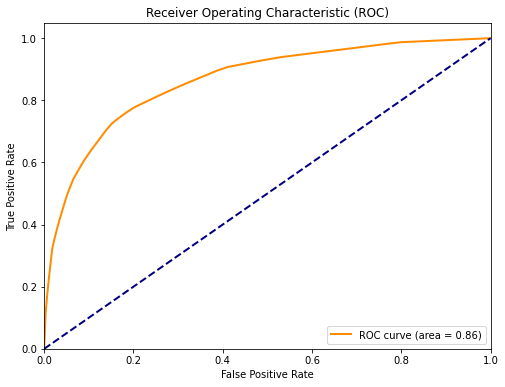

In [57]:
y_scores = best_tree.predict_proba(X_train)[:, 1]  

fpr, tpr, thresholds = roc_curve(y_train, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [58]:
best_tree_y_train = best_tree.predict(X_train)

Precision is the metric of choice for this analysis because our client would prefer false negatives to false positives. Encouraging an already immunized person to get a flu shot is less of an issue than assuming a patient will get theirs and then they don't. Promoting immunization is not cost-free; otherwise our dummy model would be the ideal. Our goal is a fitted precision: a good guess that errs on the side of negative.

In [59]:
tree_accuracy = accuracy_score(y_train, best_tree_y_train)
tree_accuracy


0.791063404892661

Our model is no longer overfit, and it is performing fairly well.

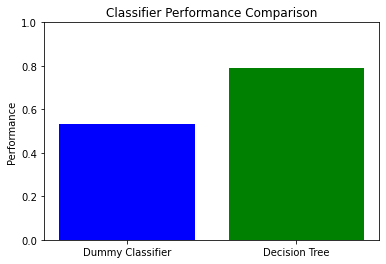

In [30]:
classifiers = ['Dummy Classifier', 'Decision Tree']
precisions = [dummy_accuracy, tree_accuracy]

plt.bar(classifiers, precisions, color=['blue', 'green'])
plt.ylabel('Performance')
plt.title('Classifier Performance Comparison')
plt.ylim(0, 1)  
plt.show()

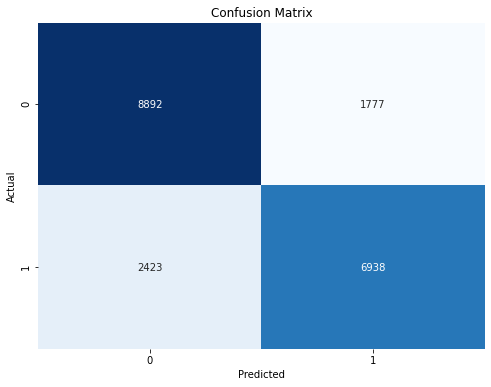

In [31]:
#We want a strong model that errs on the side of false negatives. A confusion matrix helps us visualize whether we're
#achieving that.
cm = confusion_matrix(y_train, best_tree_y_train)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Overall, our decision tree gets it right most of the time, and when it gets it wrong, it's more likely to predict a false negative than a false positive. That's what we're going for, so this is pretty good. But let's see if there's anything else we can do that gets it right even more often.

# Logistic Regression

Now we will create a logistic regression model to see how it compares to our decision tree. Since we already have a pretty solid model with our decision tree, we'll go straight to a grid search for optimal parameters.

In [60]:
log_pipe = Pipeline([('ct', col_tr),
    ('logistic', LogisticRegression(max_iter=1000))])

In [61]:
log_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('num',
                                                                   StandardScaler()),
                                                                  ('impute_nums',
                                                                   KNNImputer())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'opinion_h1n1_vacc_effective',
                                                   'opinion_h1n1_risk',
                                                   'opinion_h1n1_sick_from_vacc',
                                                   'opinion_seas_vacc_effective',
                                                   'opinion_seas_risk',
             

In [62]:
cv_results = cross_validate(estimator=log_pipe, X=X_train, y=y_train, cv=5,
                            return_train_score=True)
cv_results

{'fit_time': array([20.90099573, 18.30523372, 16.72366309, 17.73130584, 17.8301928 ]),
 'score_time': array([3.39680099, 3.23886538, 3.39677978, 3.38313508, 3.3487072 ]),
 'test_score': array([0.78981528, 0.80229656, 0.80229656, 0.79480779, 0.79955067]),
 'train_score': array([0.80136046, 0.79836495, 0.79973789, 0.80142287, 0.80004993])}

In [63]:
log_y_train = log_pipe.predict(X_train)
print(precision_score(y_train, log_y_train))

0.803559283609159


In [64]:
log_params = {'logistic__C': [0.001, 0.01, 0.1, 1, 10]}

gs_log = GridSearchCV(log_pipe, log_params, scoring='precision')

gs_log.fit(X_train, y_train)

print(gs_log.best_params_)
print(gs_log.best_score_)
#print({'logistic__C': 0.1})

{'logistic__C': 1}
0.800676912884604


In [65]:
best_log = Pipeline([('ct', col_tr),
    ('logistic', LogisticRegression(C=1, max_iter=1000))])
best_log.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('num',
                                                                   StandardScaler()),
                                                                  ('impute_nums',
                                                                   KNNImputer())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'opinion_h1n1_vacc_effective',
                                                   'opinion_h1n1_risk',
                                                   'opinion_h1n1_sick_from_vacc',
                                                   'opinion_seas_vacc_effective',
                                                   'opinion_seas_risk',
             

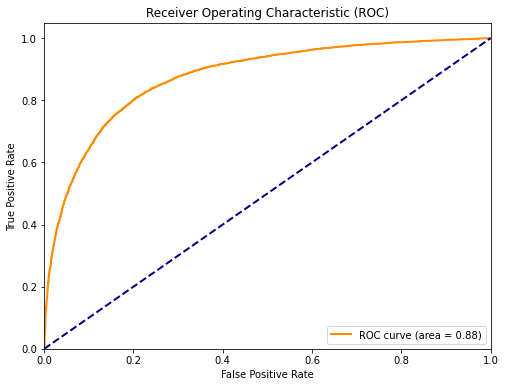

In [66]:
y_scores2 = best_log.predict_proba(X_train)[:, 1]  

fpr, tpr, thresholds = roc_curve(y_train, y_scores2)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [67]:
best_log_y_train = best_log.predict(X_train)

In [68]:
log_accuracy = accuracy_score(y_train, best_log_y_train)
log_accuracy

0.8000499251123315

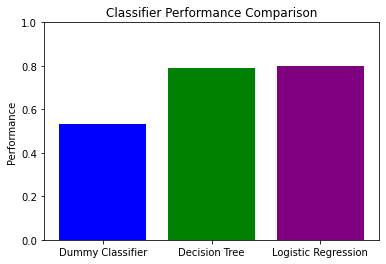

In [41]:
classifiers = ['Dummy Classifier', 'Decision Tree', 'Logistic Regression']
precisions = [dummy_accuracy, tree_accuracy, log_accuracy]

plt.bar(classifiers, precisions, color=['blue', 'green', 'purple'])
plt.ylabel('Performance')
plt.title('Classifier Performance Comparison')
plt.ylim(0, 1)  
plt.show()

Our logistic regression is just slightly beating our decision tree in precision.

In [43]:
#Check its overall performance--also solid.
f1 = f1_score(y_train, best_log_y_train)
f1

0.781404549950544

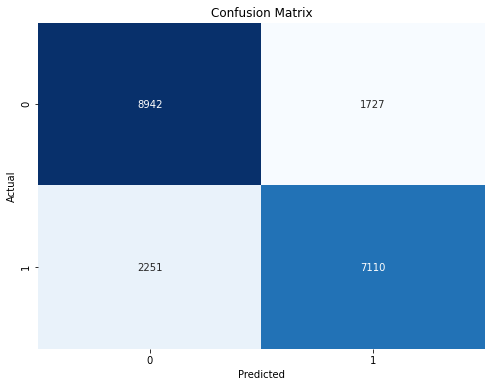

In [44]:
cm2 = confusion_matrix(y_train, best_log_y_train)

plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Our logistic regression is slightly more precise than our decision tree, making it our preferred model.

In [45]:
best_log.named_steps

{'ct': ColumnTransformer(sparse_threshold=0,
                   transformers=[('num',
                                  Pipeline(steps=[('impute_nums',
                                                   SimpleImputer(add_indicator=True,
                                                                 strategy='most_frequent')),
                                                  ('num', StandardScaler())]),
                                  ['h1n1_concern', 'h1n1_knowledge',
                                   'opinion_h1n1_vacc_effective',
                                   'opinion_h1n1_risk',
                                   'opinion_h1n1_sick_from_vacc',
                                   'opinion_seas_vacc_effective',
                                   'opinion_seas_risk',
                                   'opinion_se...
                                                                 strategy='most_frequent'))]),
                                  ['behavioral_antiviral_meds',
   

In [46]:
coeff = best_log.named_steps['logistic'].coef_
len(coeff[0])

143

In [47]:
obj = list(col_tr.named_transformers_['ohe'].named_steps['ohe'].get_feature_names())
len(obj)

96

In [48]:
num_ind = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults', 'household_children']

In [49]:
num_ind = []
for name in numbers:
    new_name = name+"_indicator"
    num_ind.append(new_name)
print(num_ind)

['h1n1_concern_indicator', 'h1n1_knowledge_indicator', 'opinion_h1n1_vacc_effective_indicator', 'opinion_h1n1_risk_indicator', 'opinion_h1n1_sick_from_vacc_indicator', 'opinion_seas_vacc_effective_indicator', 'opinion_seas_risk_indicator', 'opinion_seas_sick_from_vacc_indicator', 'household_adults_indicator', 'household_children_indicator']


In [50]:
final_num = numbers + num_ind

In [51]:
final_num_cat =  final_num + obj

In [52]:
bin_ind = []

for name in binary:
    new_name = name+'_indicator'
    bin_ind.append(new_name)

bin_ind.remove('h1n1_vaccine_indicator')
print(bin_ind)

['behavioral_antiviral_meds_indicator', 'behavioral_avoidance_indicator', 'behavioral_face_mask_indicator', 'behavioral_wash_hands_indicator', 'behavioral_large_gatherings_indicator', 'behavioral_outside_home_indicator', 'behavioral_touch_face_indicator', 'doctor_recc_h1n1_indicator', 'doctor_recc_seasonal_indicator', 'chronic_med_condition_indicator', 'child_under_6_months_indicator', 'health_worker_indicator', 'health_insurance_indicator']


In [53]:
final_bin = binary + bin_ind

In [54]:
logreg_estimator = best_log.named_steps['logistic']


coefficients = logreg_estimator.coef_
intercept = logreg_estimator.intercept_

feature_names = final_num_cat + final_bin 

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients[0]})

coef_df['Abs_Coefficient'] = abs(coef_df['Coefficient'])
sorted_coef = coef_df.sort_values(by='Abs_Coefficient', ascending=False)


print(sorted_coef.head(15))


                         Feature  Coefficient  Abs_Coefficient
129                 h1n1_vaccine     1.829001         1.829001
124         doctor_recc_seasonal     1.510007         1.510007
63                  x10_haxffmxo     0.981146         0.981146
82                  x11_dcjcmpih     0.981146         0.981146
35                  x4_65+ Years     0.908119         0.908119
123             doctor_recc_h1n1    -0.807342         0.807342
6              opinion_seas_risk     0.721745         0.721745
5    opinion_seas_vacc_effective     0.627528         0.627528
31              x4_18 - 34 Years    -0.566675         0.566675
73                  x10_saaquncn    -0.495510         0.495510
67                  x10_msuufmds     0.454227         0.454227
127                health_worker     0.441615         0.441615
72                  x10_rucpziij    -0.425898         0.425898
128             health_insurance     0.399660         0.399660
68                  x10_nduyfdeo    -0.353229         0

# A Simpler Model

### We want to go back to those features that had the highest initial correlation with vaccine status. We wonder if there's a possibility to make a useful model that requires significantly less input.

In [55]:
numbers2=['opinion_seas_vacc_effective', 'opinion_seas_risk']
binary2= ['doctor_recc_seasonal', 'h1n1_vaccine']

In [56]:
col_tr2 = ColumnTransformer(transformers=[('num', numbers_pipeline, numbers2),
                                        ('bin', binary_pipeline, binary2)],
                          remainder='drop', sparse_threshold=0)

In [58]:
#log_pipe2 = Pipeline([('ct', col_tr2),
    #('logistic', LogisticRegression(max_iter=1000))])


#param_grid = {'logistic__C': [0.001, 0.01, 0.1, 1, 10]}

#grid_search2 = GridSearchCV(log_pipe2, param_grid, cv=5, scoring='precision')

#grid_search2.fit(X_train, y_train)

#grid_search2.best_score_

print(0.7825511431355323)

0.7825511431355323


In [59]:
#grid_search2.best_params_
print({'logistic__C': 0.001})

{'logistic__C': 0.001}


In [60]:
simple_model = Pipeline([('ct', col_tr2),
    ('logistic', LogisticRegression(max_iter=1000, C=.001))])
simple_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('impute_nums',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('num',
                                                                   StandardScaler())]),
                                                  ['opinion_seas_vacc_effective',
                                                   'opinion_seas_risk']),
                                                 ('bin',
                                                  Pipeline(steps=[('impute_bin',
                                                                   SimpleImputer(add_indicator=True,
                

In [61]:
simple_model_y_train = simple_model.predict(X_train)

In [62]:
simple_model_precision = precision_score(y_train, simple_model_y_train)
simple_model_f1_score = f1_score(y_train, simple_model_y_train)
simple_model_precision, simple_model_f1_score

(0.7770211712269407, 0.7198073173529075)

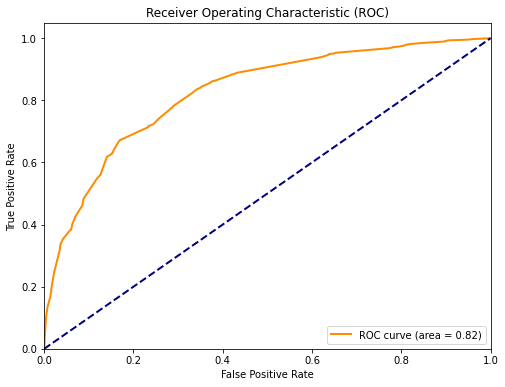

In [63]:
y_scores3 = simple_model.predict_proba(X_train)[:, 1]  

fpr, tpr, thresholds = roc_curve(y_train, y_scores3)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [64]:
simple_accuracy = accuracy_score(y_train, simple_model_y_train)
simple_accuracy

0.7560659011482775

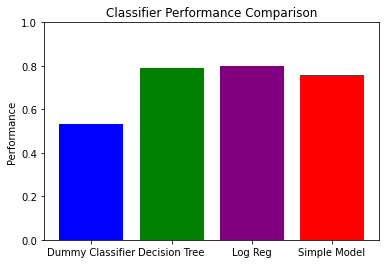

In [65]:
classifiers = ['Dummy Classifier', 'Decision Tree', 'Log Reg', 'Simple Model']
precisions = [dummy_accuracy, tree_accuracy, log_accuracy, simple_accuracy]

plt.bar(classifiers, precisions, color=['blue', 'green', 'purple', 'red'])
plt.ylabel('Performance')
plt.title('Classifier Performance Comparison')
plt.ylim(0, 1)  
plt.show()

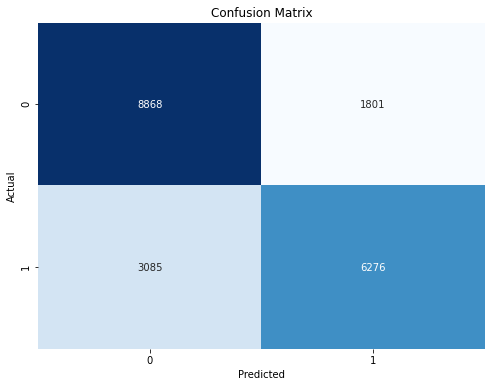

In [66]:
cm3 = confusion_matrix(y_train, simple_model_y_train)

plt.figure(figsize=(8, 6))
sns.heatmap(cm3, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Our simple model, using only four features, is performing almost as well as our 36-feature complex model. We will present it to our client as an alternative for situations where extensive data collection may be cost-prohibitive or even impossible.

# Evaluation

### Our logistic regression model outperforms our decision tree just slightly, but it does so by multiple measures. It has a higher precision score as well as overall accuracy score, and its ROC curve is slightly closer to ideal.

In [67]:
best_log_y_pred = best_log.predict(X_test)

In [68]:
final_accuracy = accuracy_score(y_test, best_log_y_pred)
final_accuracy

0.8054515500973491

In [69]:
final_f1 = f1_score(y_test, best_log_y_pred)
final_f1

0.783391695847924

In [70]:
final_precision = precision_score(y_test, best_log_y_pred)
final_precision

0.8036264112213479

In [71]:
simple_y_pred = simple_model.predict(X_test)
simple_precision = precision_score(y_test, simple_y_pred)
simple_precision

0.7840909090909091

### Our final model has a precision score of 80.4%. Our simple model is slightly less precise with a score of 78.4%.

# Recommendations

### We offer our logistic regression model to help the healthcare organization predict whether a patient will get the seasonal flu shot.
### We also offer a simplified model that achieves very similar results with only four inputs. Determining these four features about a patient is likely much more achievable than gathering 37 data points. The ease of making predictions about a patient may compensate for the slight loss of precision.

# Next Steps

### The model can be improved going forward if our client keeps track of its efforts to promote vaccination. We can add a feature based on whether a patient received targeted encouragement, and see the effect that has on vaccine uptake. It seems likely that some people are unvaccinated due to hesitancy or personal conviction, while others simply don't put in the effort to make sure they get their shot every season. Teasing out the differences in those two groups may suggest further ways to categorize and effectively reach these potentially different groups.